This notebook contains code to perform differential expression analysis across tumor regions for ground truth and predicted gene expression values, and compare findings from both

In [3]:
import pandas as pd
import numpy as np
import os
import anndata
import scanpy as sc

In [192]:
top_250_genes = pd.read_csv("bucket/top_250_genes_new.txt", sep = "\t", header = None)
gene_mapper = pd.read_csv("bucket/eid_to_hgnc_new.csv", index_col=0).set_index("Gene ID")

In [187]:
sample_name = 'BC23450'
replicate_name = 'D2'

In [188]:
adata_path = f'bucket/anndata/{sample_name}_{replicate_name}.h5ad'
annotation_path = f'bucket/coords/{sample_name}_{replicate_name}_Coords.tsv.gz'
prediction_path = f'bucket/models/knn_pooling/regularized_alpha_estimated_0.5_elastic_net/predictions/valid_predictions.csv'

In [189]:
adata_gt = anndata.read_h5ad(adata_path)
# subset to top 250 genes
adata_gt_subset = adata_gt[:, adata_gt.var_names.isin(top_250_genes[0])]
annotation = pd.read_csv(annotation_path, sep = "\t", compression="gzip", index_col = 0).set_index('spot')
prediction = pd.read_csv(prediction_path)
# subset prediction to sample
prediction_subset = prediction.loc[(prediction["Patient"] == sample_name) & (prediction["Replicate"] == replicate_name)]
# creating an AnnData object for predictions (if an adata exists containing predictions, then load that)
adata_pred = anndata.AnnData(X=prediction_subset.iloc[:, 3:].values, obs=pd.DataFrame(index=prediction_subset['Index'].values), var=pd.DataFrame(index=prediction_subset.columns[3:]))


In [190]:
# add annotations to adata's
adata_gt_subset.obs = pd.merge(adata_gt_subset.obs, annotation, left_index=True, right_index=True)
adata_pred.obs = pd.merge(adata_pred.obs, annotation, left_index=True, right_index=True)

In [202]:
adata_gt_subset.var_names

Index(['ENSG00000005884', 'ENSG00000006210', 'ENSG00000008130',
       'ENSG00000011009', 'ENSG00000013374', 'ENSG00000013725',
       'ENSG00000014164', 'ENSG00000025796', 'ENSG00000027847',
       'ENSG00000031823',
       ...
       'ENSG00000253626', 'ENSG00000255198', 'ENSG00000255823',
       'ENSG00000256618', 'ENSG00000260260', 'ENSG00000267795',
       'ENSG00000269028', 'ENSG00000279576', 'ENSG00000281181',
       'ENSG00000281383'],
      dtype='object', length=250)

In [203]:
# map the gene names to hgnc names
adata_gt_subset.var_names = gene_mapper.loc[adata_gt_subset.var_names]['Gene Name']
adata_pred.var_names = gene_mapper.loc[adata_pred.var_names]['Gene Name']

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


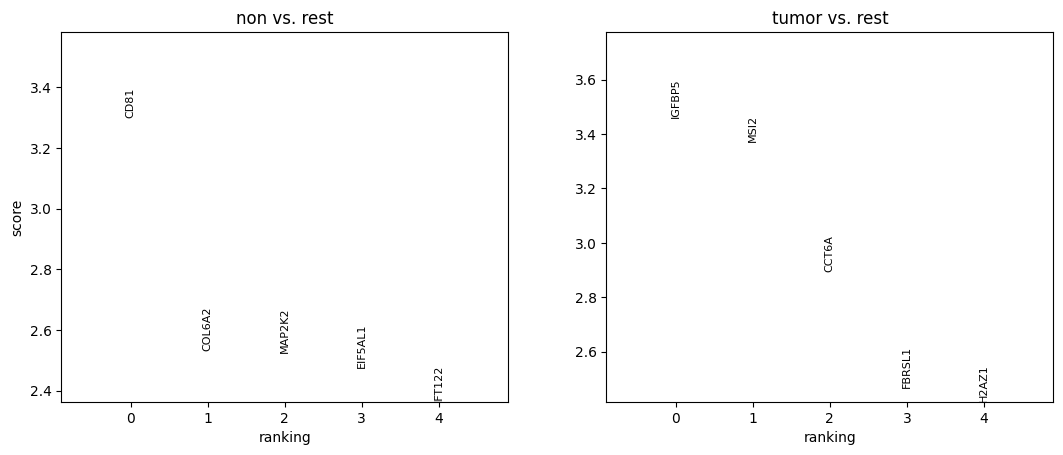

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


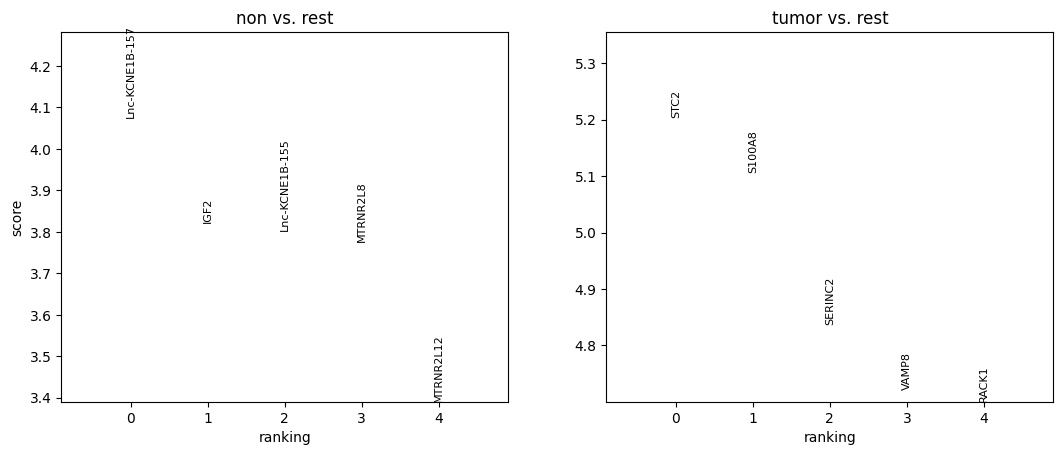

In [204]:
# differentially expressed genes between tumor and non tumor regions

# ground truth
sc.tl.rank_genes_groups(adata_gt_subset, "tumor", method="wilcoxon")
sc.pl.rank_genes_groups(adata_gt_subset, n_genes=5, sharey=False)

# prediction
sc.tl.rank_genes_groups(adata_pred, "tumor", method="wilcoxon")
sc.pl.rank_genes_groups(adata_pred, n_genes=5, sharey=False)

In [216]:
# save tabular
print("DEGs of tumor/non_tumor in ground truth")
print(pd.DataFrame(adata_gt_subset.uns["rank_genes_groups"]["names"]).head())

print("DEGs of tumor/non_tumor in prediction")
print(pd.DataFrame(adata_pred.uns["rank_genes_groups"]["names"]).head())

DEGs of tumor/non_tumor in ground truth
       non   tumor
0     CD81  IGFBP5
1   COL6A2    MSI2
2   MAP2K2   CCT6A
3  EIF5AL1  FBRSL1
4   IFT122   H2AZ1
DEGs of tumor/non_tumor in prediction
              non    tumor
0  Lnc-KCNE1B-157     STC2
1            IGF2   S100A8
2  Lnc-KCNE1B-155  SERINC2
3        MTRNR2L8    VAMP8
4       MTRNR2L12    RACK1


In [228]:
adata_gt.obs = pd.merge(adata_gt.obs, annotation, left_index=True, right_index=True)
sc.tl.rank_genes_groups(adata_gt, "tumor", method="wilcoxon")


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

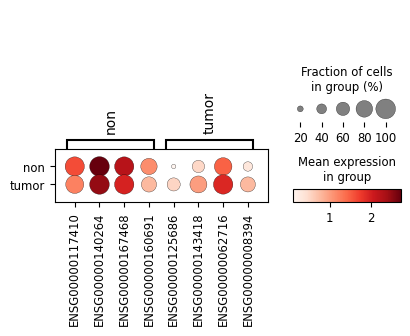

               non            tumor
0  ENSG00000117410  ENSG00000125686
1  ENSG00000140264  ENSG00000143418
2  ENSG00000167468  ENSG00000062716
3  ENSG00000160691  ENSG00000008394
4  ENSG00000110651  ENSG00000117335


In [232]:
# adata_gt.var_names = gene_mapper.loc[adata_gt.var_names]['Gene Name']
adata_gt.var_names_make_unique()
sc.pl.rank_genes_groups_dotplot(adata_gt, n_genes=4)
print(pd.DataFrame(adata_gt.uns["rank_genes_groups"]["names"]).head())


Visualizations

Dotplots across conditions, enrichment of markers

/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

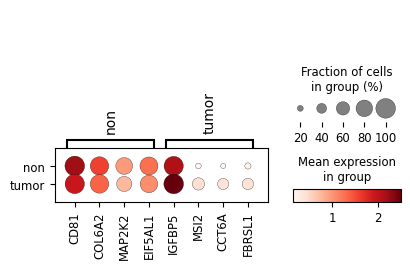

In [206]:
adata_gt_subset.var_names_make_unique()
sc.pl.rank_genes_groups_dotplot(adata_gt_subset, n_genes=4)


/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

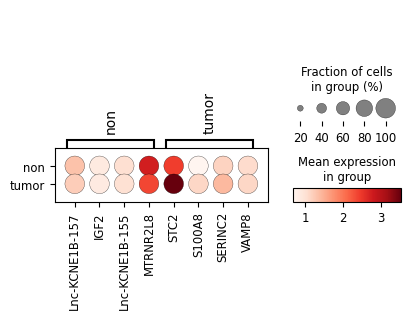

In [208]:
adata_pred.var_names_make_unique()
sc.pl.rank_genes_groups_dotplot(adata_pred, n_genes=4)


/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

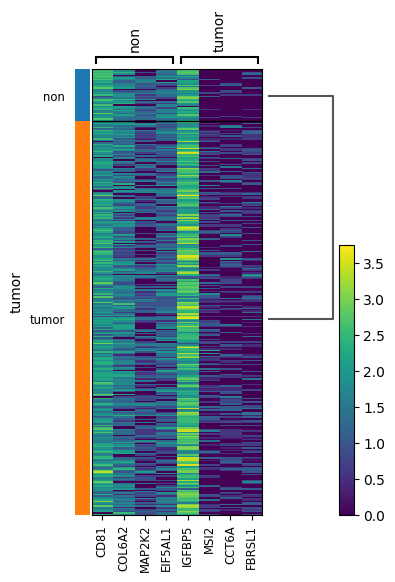

In [224]:
sc.pl.rank_genes_groups_heatmap(adata_gt_subset, n_genes=4)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is 

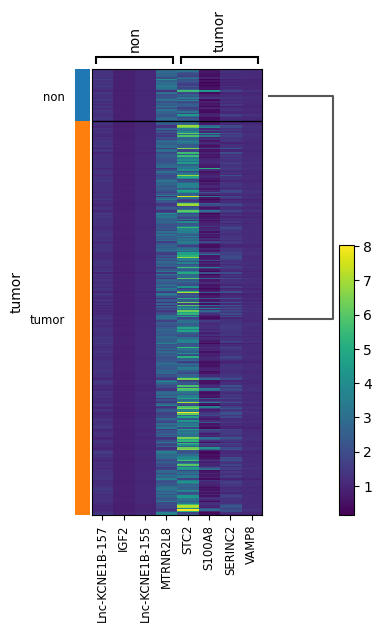

In [222]:
sc.pl.rank_genes_groups_heatmap(adata_pred, n_genes=4)
